# Extraction

In [12]:
from datasets import load_dataset
from pathlib import Path
import json
import random
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from IPython.display import display
from openai import AsyncOpenAI

# Import from src modules
from src import (
    convert_docs_to_pdf,
    process_pdfs_with_mineru,
    extract_tables_from_output,
    merge_consecutive_tables,
    find_summary_compensation_in_doc,
    extract_all_summary_compensation,
    save_classification_results,
    save_extraction_results,
    display_all_results,
    display_table_preview,
    TableType
)

# Setup directories
Path("pdfs").mkdir(exist_ok=True)
Path("output").mkdir(exist_ok=True)

# Base path
BASE_PATH = Path("/home/pdipasquale/MIIA/stuff")

# Load dataset and sample random docs
dataset = load_dataset("json", data_files="/home/pdipasquale/MIIA/stuff/data/DEF14A_all.jsonl")
all_docs = dataset["train"]

random.seed(5436)
indices = random.sample(range(len(all_docs)), 50)
docs = all_docs.select(indices)
# Setup VLM client
client = AsyncOpenAI(base_url="http://localhost:8000/v1", api_key="dummy")
MODEL = "Qwen/Qwen3-VL-32B-Instruct"


In [13]:
convert_docs_to_pdf(docs)
failed, success = process_pdfs_with_mineru(max_concurrent=16)
all_tables, extraction_stats = extract_tables_from_output()

100%|██████████| 50/50 [00:00<00:00, 527.76it/s]


Found 150 PDFs total
  - Already processed (skipped): 150
  - To process: 0
Nothing to process!
=== Extraction Summary ===
Total output directories: 150
  - MinerU processed: 150
  - MinerU NOT processed (no content_list.json): 0

Of processed documents:
  - With tables: 146
  - Without tables: 4

Total tables extracted: 3576

📄 Documents with 0 tables:
    - 1689311_2018_0000871839-18-000068
    - 793347_2017_0000798086-17-000026
    - 80257_2006_0000871839-06-000015
    - 856517_2006_0001318148-06-000431


# check

In [14]:

with open("all_tables.json") as f:
    all_tables = json.load(f)

print(f"Total tables: {len(all_tables)}")

Total tables: 3576


In [15]:
# # Get unique doc sources from tables
# doc_sources = list(set(t.get('source_doc') for t in all_tables))
# print(f"Documents with tables: {len(doc_sources)}")

# # Check which docs are missing tables
# all_output_dirs = list(Path("output").glob("*"))
# output_doc_names = set(d.name for d in all_output_dirs if d.is_dir())
# doc_sources_set = set(doc_sources)

# missing = output_doc_names - doc_sources_set
# print(f"Documents without tables: {len(missing)}")

# # Get links for missing documents
# if missing:
#     print("\nDocuments without tables:")
#     for doc_name in sorted(missing):
#         metadata_path = BASE_PATH / "output" / doc_name / "metadata.json"
#         if metadata_path.exists():
#             with open(metadata_path) as f:
#                 meta = json.load(f)
#             url = meta.get('filing_html_index', 'N/A')
#             print(f"  - {doc_name}:")
#             print(f"    {url}")
#         else:
#             print(f"  - {doc_name}: metadata.json not found")

# Classify

In [16]:
doc_sources = list(set(t.get('source_doc') for t in all_tables))

source_doc = doc_sources[99]
metadata_path = BASE_PATH / "output" / source_doc / "metadata.json"

with open(metadata_path) as f:
                meta = json.load(f)
if meta["sic"] == "NULL":
    print("-----------FONDO----------")
meta

# 38, 55

{'_id': '781902_DEF 14A_2008_0001072613-09-000588',
 'cik': '781902',
 'company': 'WASTE TECHNOLOGY CORP',
 'filing_type': 'DEF 14A',
 'filing_date': '2009-03-20T00:00:00',
 'period_of_report': '2008-04-20T00:00:00',
 'sic': '3569',
 'state_of_inc': 'DE',
 'state_location': 'FL',
 'fiscal_year_end': '1031',
 'filing_html_index': 'https://www.sec.gov/Archives/edgar/data/781902/0001072613-09-000588-index.html',
 'htm_filing_link': 'NULL',
 'complete_text_filing_link': 'https://www.sec.gov/Archives/edgar/data/781902/000107261309000588/0001072613-09-000588.txt',
 'filename': '781902_DEF 14A_2008_0001072613-09-000588.txt',
 'accession_number': '0001072613-09-000588',
 'year': 2009}

Document: 781902_2009_0001072613-09-000588
Tables in document: 8
SEC Link: https://www.sec.gov/Archives/edgar/data/781902/0001072613-09-000588-index.html

--- Table 0 (page 3) ---
Type: beneficial_ownership (0.99)
Reason:
  Table lists beneficial owners (LaRita R. Boren, Alexander C. Toppan) with share
  amounts and ownership percentages, matching the definition of
  beneficial_ownership. No compensation data present.


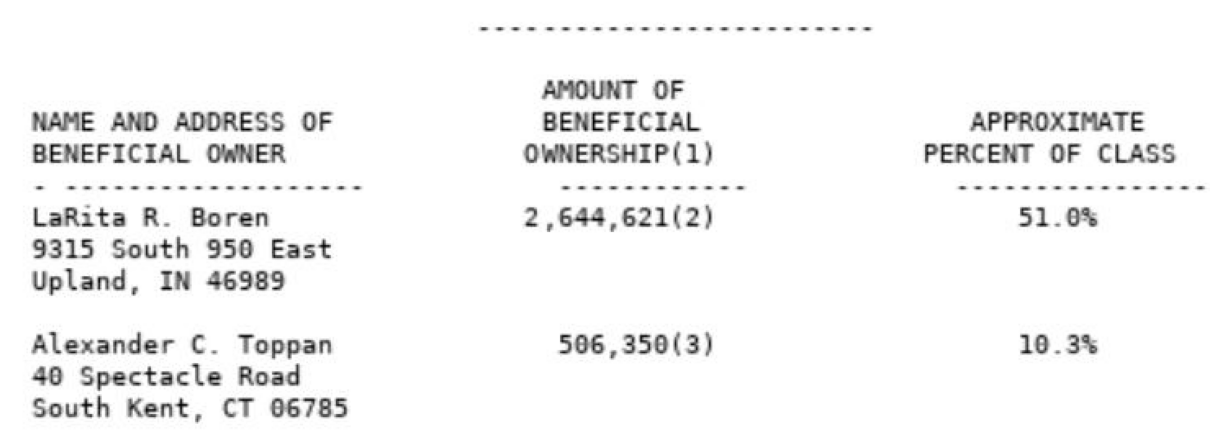


--- Table 1 (page 7) ---
Type: beneficial_ownership (0.99)
Reason:
  Table lists directors and officers with shares beneficially owned and percent of
  class, matching the definition of beneficial_ownership. No compensation data is
  present.


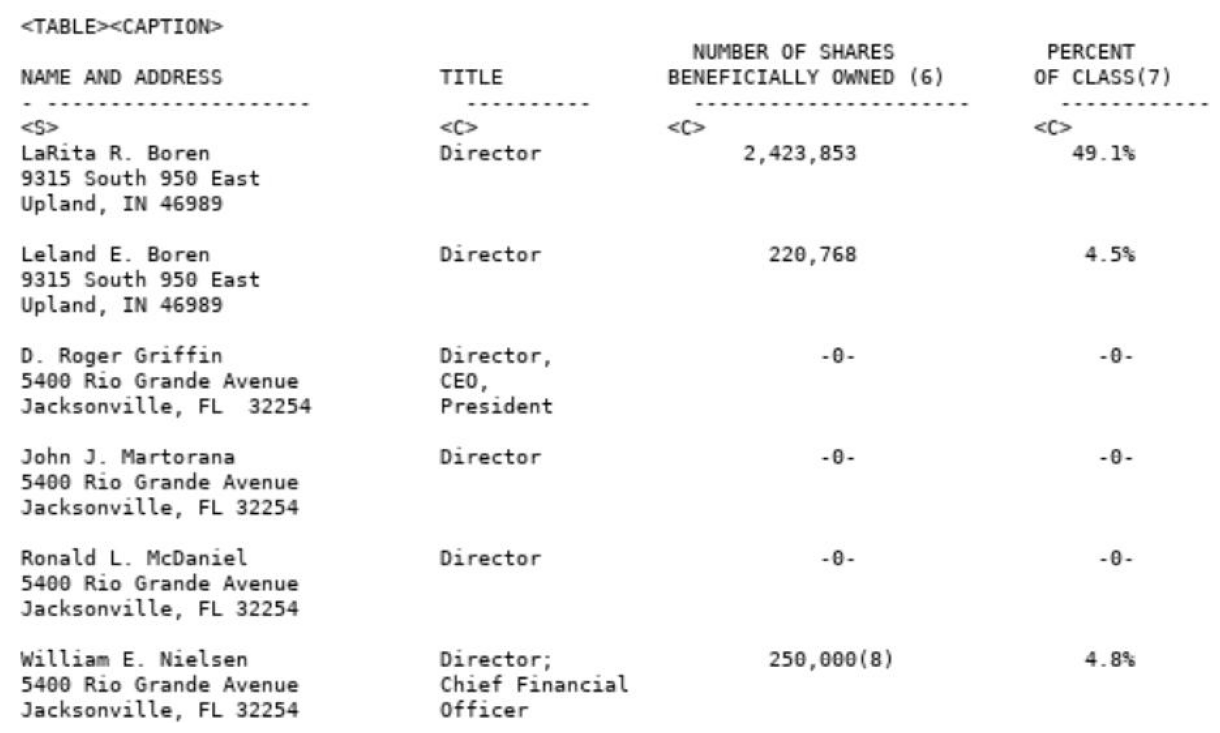


--- Table 2 (page 8) ---
Type: other (0.95)
Reason:
  No content provided; only caption and footnotes exist. Cannot classify as any
  specific table type without data or headers.
Image not found: /home/pdipasquale/MIIA/stuff/output/781902_2009_0001072613-09-000588/781902_2009_0001072613-09-000588/vlm

--- Table 3 (page 10) ---
Type: summary_compensation (0.95)
Reason:
  Table has required columns: Name, Year, Salary, Bonus, Total Compensation, and
  Long Term Awards. Structure matches SEC's Summary Compensation Table. However,
  data rows are placeholders (<C>), so is_header_only = True.


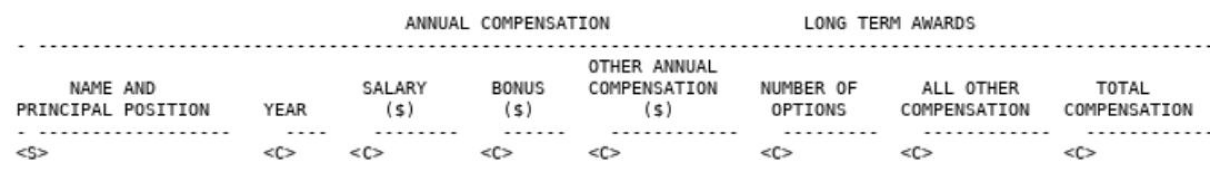


--- Table 4 (page 11) ---
Type: outstanding_equity (0.95)
Reason:
  Table titled 'OUTSTANDING EQUITY AWARDS AT FISCAL YEAR-END' shows unvested
  stock/options for executives at year-end, matching definition of
  outstanding_equity. No salary/bonus/total compensation columns present.


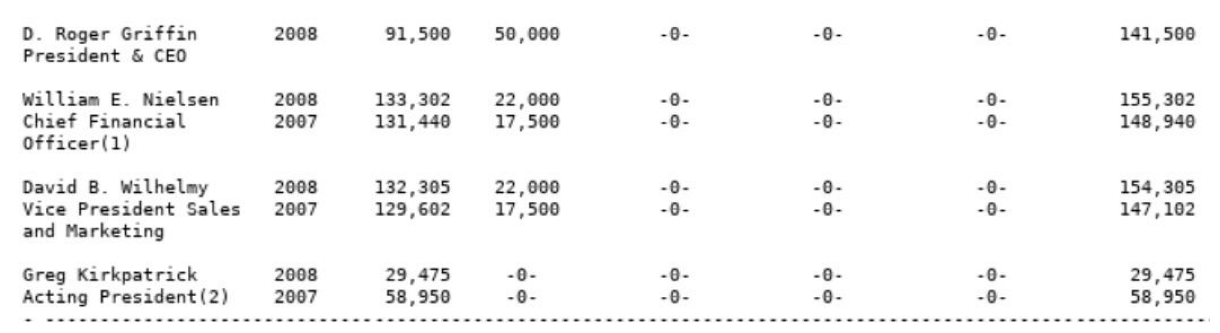


--- Table 5 (page 11) ---
Type: outstanding_equity (0.95)
Reason:
  Table shows unexercised options and unvested stock awards for executives,
  matching the definition of 'Outstanding Equity' with grant details and vesting
  status.


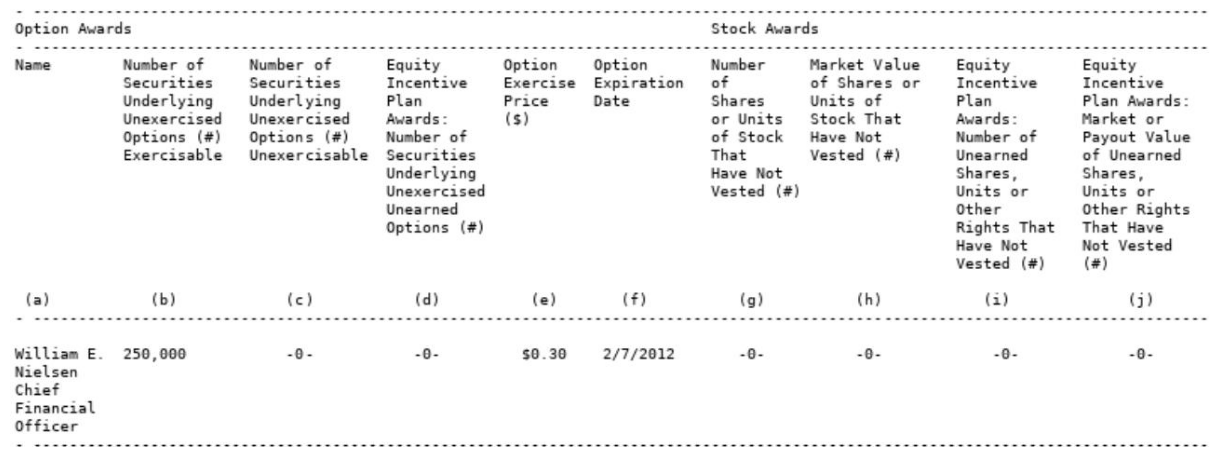


--- Table 6 (page 12) ---
Type: director_compensation (0.99)
Reason:
  Table shows compensation for directors, not executives. Contains 'Fees Earned or
  Paid in Cash' and 'Total' columns with dollar amounts for multiple directors,
  matching director_compensation definition.


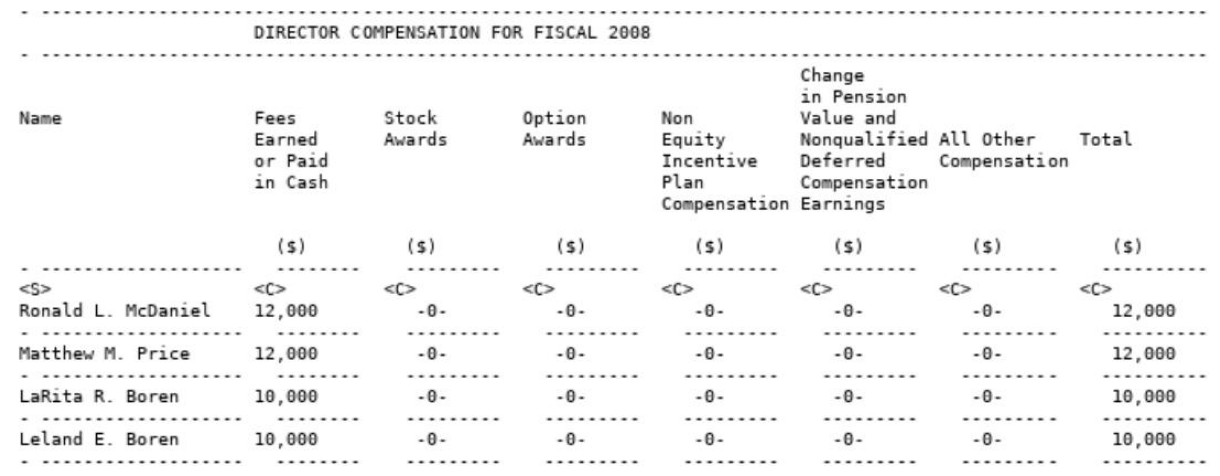


--- Table 7 (page 14) ---
Type: other (0.95)
Reason:
  This table shows audit and tax fees paid to auditors, not executive
  compensation. It lacks executive names, salary, bonus, or stock awards. It is a
  fee disclosure table, not a compensation table.


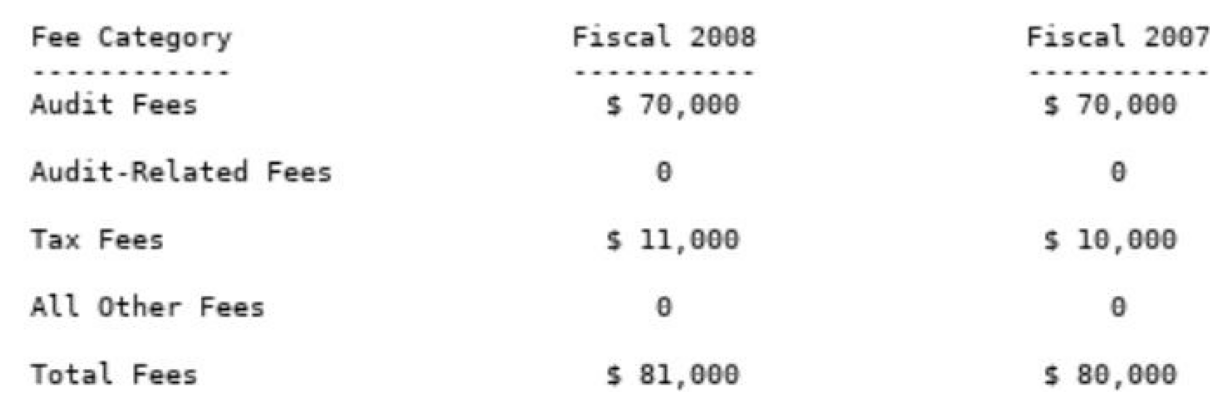


Found 1 Summary Compensation Tables


In [17]:
# Find summary compensation tables in a document
found = await find_summary_compensation_in_doc(
    doc_source=source_doc,
    all_tables=all_tables,
    client=client,
    model=MODEL,
    base_path=BASE_PATH,
    display_func=display,
    plt_module=plt,
    pil_image_class=PILImage
)

In [19]:
# Merge consecutive tables (header + data tables split across pages)
source_doc = found[0]['table']['source_doc']
# MinerU crea struttura annidata: output/doc_source/doc_source/vlm/
images_base_dir = Path(f"output/{source_doc}/{source_doc}/vlm")

found = merge_consecutive_tables(found, images_base_dir, all_tables)

📎 Merged 4 tables (pages [10, 11, 12])


In [20]:
# Extract structured data from tables
extracted = await extract_all_summary_compensation(
    found_tables=found,
    all_tables=all_tables,
    client=client,
    model=MODEL,
    base_path=BASE_PATH,
    metadata=meta
)

# Save results
save_classification_results(found, BASE_PATH / "output" / source_doc, metadata=meta)
save_extraction_results(extracted, BASE_PATH / "output" / source_doc, metadata=meta)

✓ Extracted table 3 [MERGED]: 7 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/781902_2009_0001072613-09-000588/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/781902_2009_0001072613-09-000588/extraction_results.json


PosixPath('/home/pdipasquale/MIIA/stuff/output/781902_2009_0001072613-09-000588/extraction_results.json')

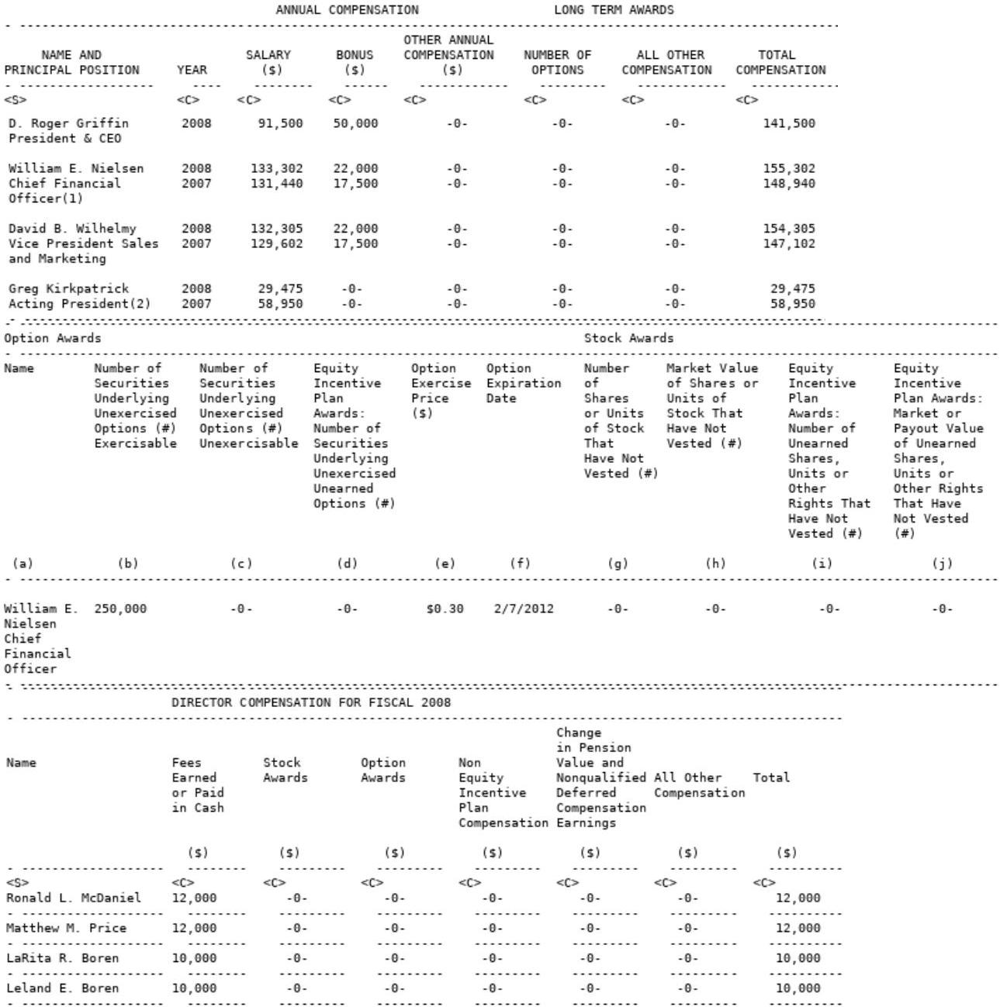

In [21]:
# Visualize all results with images, JSON, and SEC filing links
display_all_results(
    extracted_list=extracted,
    found_tables=found,
    metadata=meta,
    base_path=BASE_PATH,
    pil_image_class=PILImage
)